# 1. Pernyataan Masalah & Urgensi Bisnis

## Tantangan Industri Ritel

Dalam ekosistem ritel yang dinamis, kemampuan untuk mengukur dan memahami Nilai Seumur Hidup Pelanggan (Customer Lifetime Value) bukan lagi sekadar opsi, melainkan imperatif strategis. Bisnis yang gagal memetakan kontribusi nilai dari setiap pelanggan berisiko kehilangan profitabilitas akibat alokasi sumber daya pemasaran yang tidak efisien. Untuk mengatasi tantangan tersebut, kami menerapkan metode Segmentasi Pelanggan yang mengintegrasikan analisis RFM (Recency, Frequency, Monetary) dengan analisis asosiasi menggunakan algoritma FP-Growth.

**Segmentasi Berbasis RFM**

Segmentasi pelanggan merupakan proses strategis untuk mengelompokkan basis pelanggan yang heterogen ke dalam segmen-segmen homogen berdasarkan karakteristik dan perilaku transaksi. Dalam penelitian ini, fokus segmentasi diarahkan pada aspek perilaku pembelian historis.Kerangka kerja RFM digunakan untuk:
- Recency: Mengukur seberapa baru pelanggan melakukan transaksi,
- Frequency: Menilai seberapa sering pelanggan bertransaksi,
- Monetary: Mengukur total nilai belanja pelanggan.

**Analisis Pola Produk dengan FP-Growth**

Sebagai pelengkap segmentasi pelanggan, algoritma FP-Growth (Frequent Pattern Growth) diterapkan untuk mengekstraksi pola asosiasi antarproduk berdasarkan riwayat transaksi. Metode ini bertujuan untuk mengidentifikasi kombinasi produk yang sering dibeli secara bersamaan tanpa harus melakukan proses candidate generation yang kompleks. Hasil dari analisis FP-Growth dimanfaatkan sebagai dasar dalam:
- Menentukan strategi bundling produk,
- Merancang promosi lintas produk (cross-selling),
- Meningkatkan nilai transaksi rata-rata (average order value).

## Tujuan Analisis
Tujuan utama dari inisiatif ini adalah membangun hierarki nilai pelanggan yang jelas. Dengan menerapkan analisis RFM, kami bertujuan untuk:

1. Mengidentifikasi Segmen Prioritas: Memisahkan pelanggan ke dalam tingkatan nilai yang berbeda, mulai dari segmen "High-Value" (interaksi tinggi, frekuensi sering, nilai belanja besar) hingga "Low-Value".

2. Optimasi Strategi: Memberikan landasan data bagi manajemen untuk merancang strategi retensi dan promosi yang spesifik untuk setiap tingkatan segmen.

3. Perumusan Strategi Bundling Produk: Mengidentifikasi kombinasi produk potensial melalui FP-Growth sebagai dasar penyusunan paket bundling yang relevan dengan perilaku belanja pelanggan, sehingga mampu meningkatkan penjualan dan efisiensi strategi pemasaran.

# 2. Persiapan Lingkungan & Ingesti Data

Sebelum memulai analisis teknis, perlu dibangun **fondasi kerja yang kokoh** dengan menyiapkan pustaka, setting visualisasi, dan memuat dataset. Tahap ini mencakup beberapa langkah penting:

---

## 2.1 Impor Pustaka Analitik

Pustaka Python yang digunakan meliputi:

- `pandas` → manipulasi data  
- `numpy` → komputasi numerik  
- `matplotlib` & `seaborn` → visualisasi data  
- `scikit-learn` → preprocessing dan algoritma machine learning  
- `yellowbrick` → visualisasi cluster (Elbow Method)
- `mlextend` → analisis pola pembelian produk

---

## 2.2 Setting Visualisasi

- Mengatur **tema dan palet warna** agar visualisasi konsisten dan profesional:  
  - `whitegrid` → grid putih untuk latar yang bersih  
  - Palet `deep` → warna lembut dan mudah dibedakan

---

## 2.3 Pemuatan Dataset

- Membaca dataset transaksi mentah dari file CSV ke dalam environment Python.  
- Menyimpan salinan data asli untuk menjaga **integritas dataset mentah** selama proses analisis.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import textwrap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import fpgrowth, association_rules

sns.set(style="whitegrid", palette="deep")

df_ = pd.read_csv('OnlineRetailDataset.csv', encoding='ISO-8859-1')
df = df_.copy()

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 3. Data Preprocessing & Quality Assurance

Kualitas wawasan yang dihasilkan sangat bergantung pada **kebersihan data** yang diolah. Oleh karena itu, kami menerapkan serangkaian protokol pembersihan data yang ketat untuk memastikan **integritas** dan **validitas** hasil analisis akhir.

Berikut adalah tahapan transformasi data yang kami lakukan:

---

## 3.1 Standardisasi Format Waktu (Temporal Formatting)
- Kolom `InvoiceDate` dikonversi ke dalam **format datetime yang baku**.
- Langkah ini esensial untuk menjamin akurasi perhitungan durasi dalam analisis **Recency**.

---

## 3.2 Validasi Identitas Pelanggan (Customer-Centric Filtering)
- Fokus analisis adalah membedah perilaku pelanggan (**Customer Centric**).
- Entri data yang **tidak memiliki `CustomerID`** dihapus.
- Memastikan setiap segmen yang terbentuk benar-benar mewakili pelanggan yang teridentifikasi, bukan transaksi anonim.

---

## 3.3 Pembersihan Noise & Anomali Data
Untuk menjaga validitas perhitungan finansial (terutama pada metrik **Monetary**), dilakukan filtrasi terhadap data yang tidak relevan:

1. **Eliminasi Duplikasi**  
   - Menghapus data ganda untuk mencegah bias frekuensi.

2. **Penghapusan Transaksi Batal**  
   - Mengeluarkan transaksi dengan kode invoice diawali huruf `'C'` (Cancellations) agar tidak mendistorsi performa penjualan riil.

3. **Koreksi Nilai Negatif**  
   - Menghapus baris dengan `Quantity` atau `UnitPrice` bernilai **nol/negatif**.  
   - Memastikan kalkulasi pendapatan (**Revenue**) tetap logis dan akurat.


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Duplikat awal: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplikat akhir: {df.duplicated().sum()}")
df.dropna(subset=['CustomerID'], inplace=True)

df['InvoiceNo'] = df['InvoiceNo'].astype(str)

is_cancelled = df['InvoiceNo'].str.startswith('C')
cancelled_count = is_cancelled.sum()

if cancelled_count > 0:
    df = df[~is_cancelled]

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

df['Revenue'] = df['Quantity'] * df['UnitPrice']

print(f"Data Bersih Final: {df.shape}")

Duplikat awal: 5268
Duplikat akhir: 0
Data Bersih Final: (392692, 9)


In [ ]:
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
df['order_date'] = [d.date() for d in df['InvoiceDate']]
df['order_time'] = [d.time() for d in df['InvoiceDate']]

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,order_date,order_time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00


# 4. Exploratory Data Analysis (EDA): Menggali Wawasan Bisnis

Sebelum menerapkan algoritma segmentasi yang kompleks, kami melakukan langkah fundamental: **menyelami data** untuk membedah anatomi bisnis secara menyeluruh. Tahap eksplorasi ini bukan sekadar visualisasi data, melainkan upaya strategis untuk **memvalidasi hipotesis awal** dan memahami **dinamika pasar** yang mendasari setiap transaksi.

Fokus utama dalam fase ini mencakup lima dimensi analisis:

---

## 4.1 Dinamika Pendapatan Bulanan (Monthly Revenue Trend)

- Memantau fluktuasi omzet dari waktu ke waktu.  
- Mengidentifikasi **pola pertumbuhan**, **efek musiman (seasonality)**, dan **kesehatan finansial bisnis**.

---

## 4.2 Analisis Kinerja Produk (Product Performance)

- Mengidentifikasi produk-produk **"bintang"** yang menjadi penopang utama pendapatan.  
- Penting untuk strategi **inventaris dan pemasaran**.

---

## 4.3 Sebaran Geografis Pelanggan

- Memetakan **asal negara** transaksi.  
- Memahami **jangkauan pasar global** dan potensi ekspansi wilayah baru.

---

## 4.4 Pola Waktu Belanja (Behavioral Timing)

- Menganalisis distribusi waktu transaksi (**hari dan jam**).  
- Menemukan **peak hours** untuk strategi pemasaran.

---

## 4.5 Analisis Frekuensi Item (Top 20 Most Frequent Items)

- Mengidentifikasi **20 barang yang paling sering dibeli**.  
- Mendukung strategi **bundling**, **cross-selling**, dan **manajemen stok**.

---

Dengan lima dimensi ini, kita memperoleh **pemahaman mendalam** tentang pola bisnis, produk unggulan, perilaku pelanggan, dan tren finansial.  


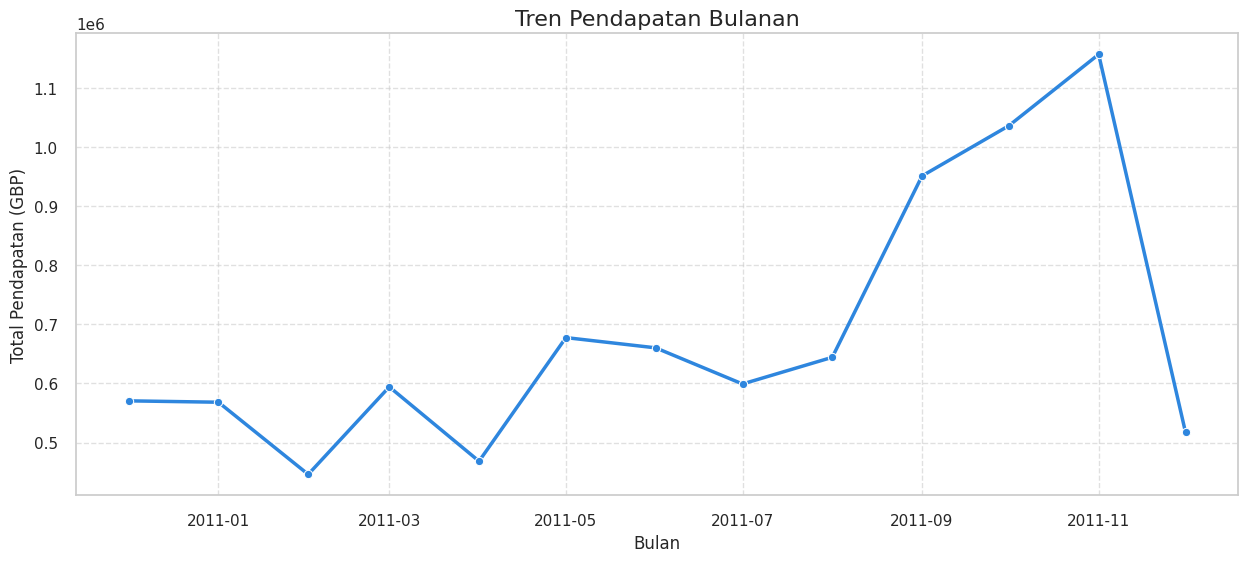

In [ ]:
df['Month_Year'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('Month_Year')['Revenue'].sum().reset_index()
monthly_revenue['Month_Year'] = monthly_revenue['Month_Year'].dt.to_timestamp()

plt.figure(figsize=(15, 6))
sns.lineplot(x='Month_Year', y='Revenue', data=monthly_revenue, marker='o', color='#2e86de', linewidth=2.5)
plt.title('Tren Pendapatan Bulanan', fontsize=16)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Total Pendapatan (GBP)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/tmp/ipython-input-634378049.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-634378049.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


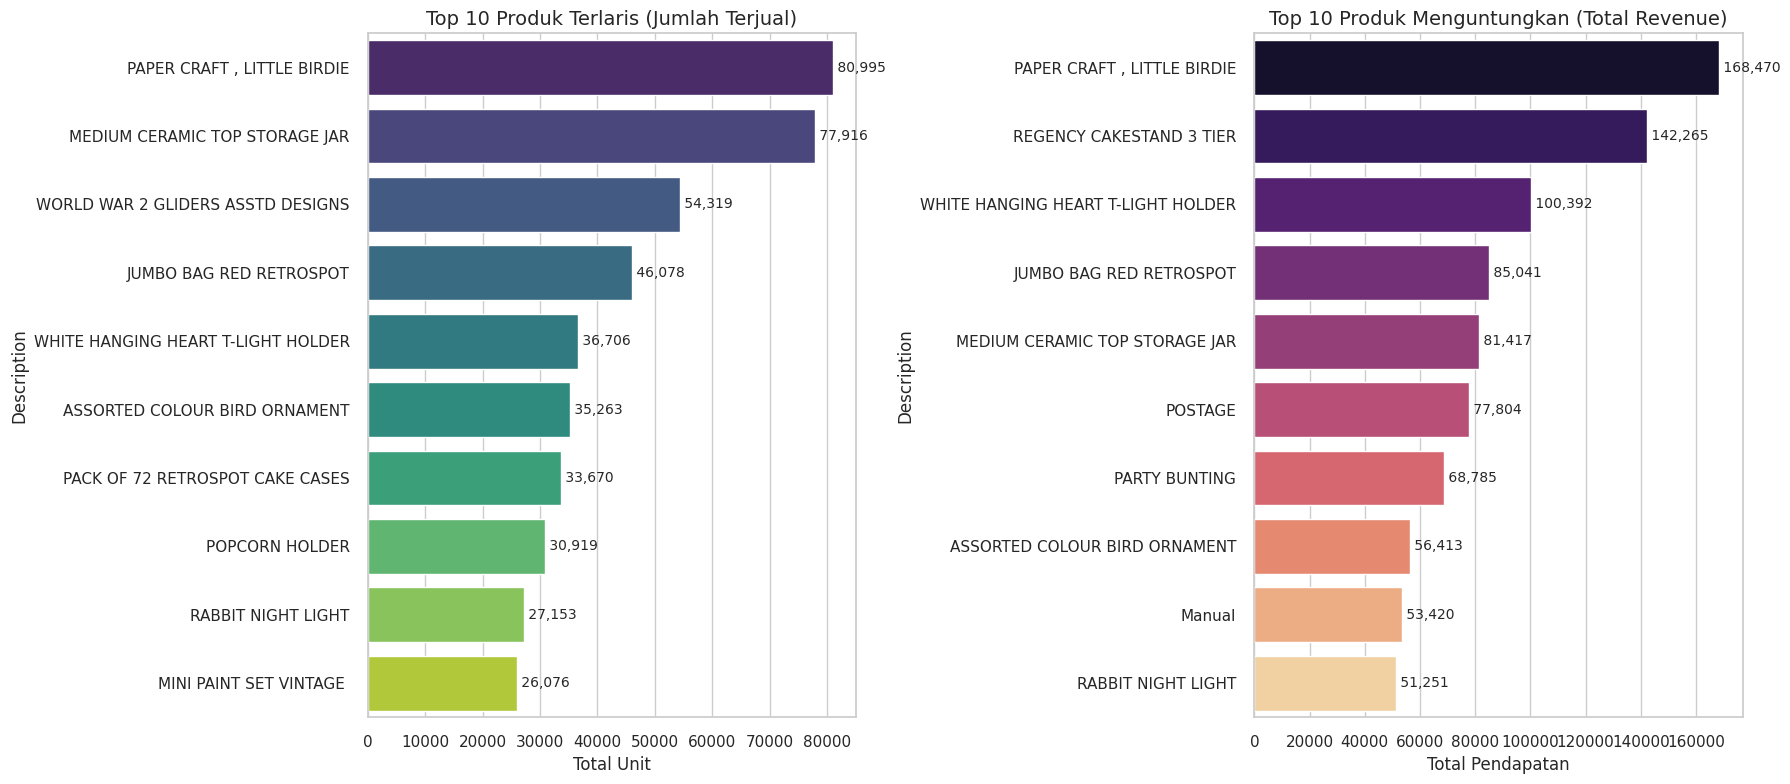

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

top_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

sns.barplot(
    x=top_qty.values,
    y=top_qty.index,
    ax=axes[0],
    palette='viridis'
)

axes[0].set_title('Top 10 Produk Terlaris (Jumlah Terjual)', fontsize=14)
axes[0].set_xlabel('Total Unit')

for i, v in enumerate(top_qty.values):
    axes[0].text(v, i, f' {v:,.0f}', va='center', fontsize=10)

top_rev = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

sns.barplot(
    x=top_rev.values,
    y=top_rev.index,
    ax=axes[1],
    palette='magma'
)

axes[1].set_title('Top 10 Produk Menguntungkan (Total Revenue)', fontsize=14)
axes[1].set_xlabel('Total Pendapatan')

for i, v in enumerate(top_rev.values):
    axes[1].text(v, i, f' {v:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipython-input-2793730053.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


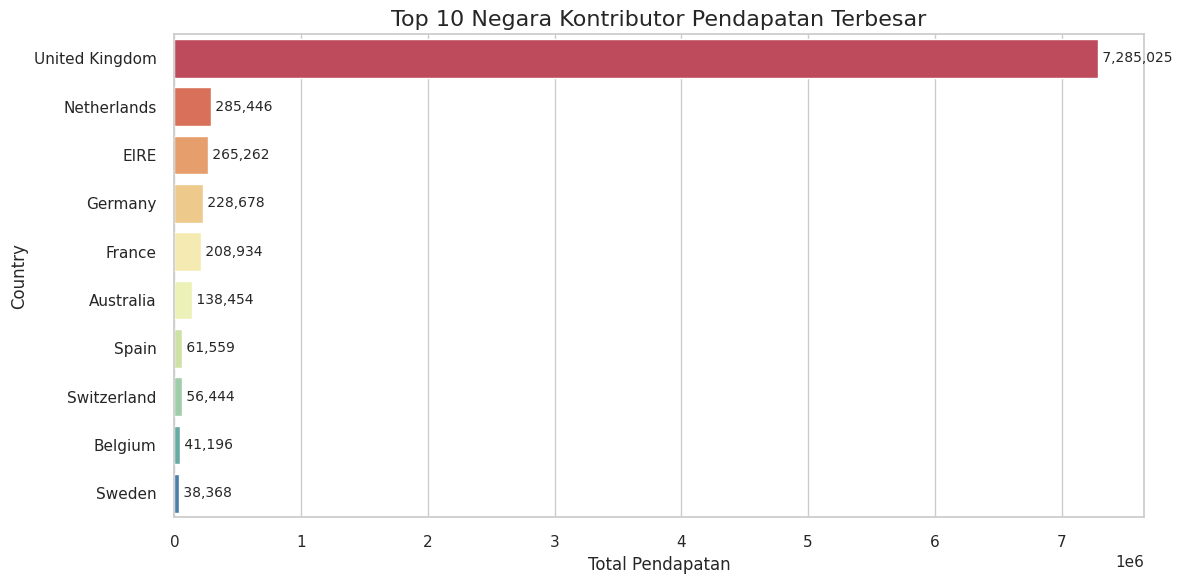

In [ ]:
country_rev = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

plot = sns.barplot(
    x=country_rev.values,
    y=country_rev.index,
    palette='Spectral'
)

plt.title('Top 10 Negara Kontributor Pendapatan Terbesar', fontsize=16)
plt.xlabel('Total Pendapatan')

for i, v in enumerate(country_rev.values):
    plot.text(v, i, f' {v:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


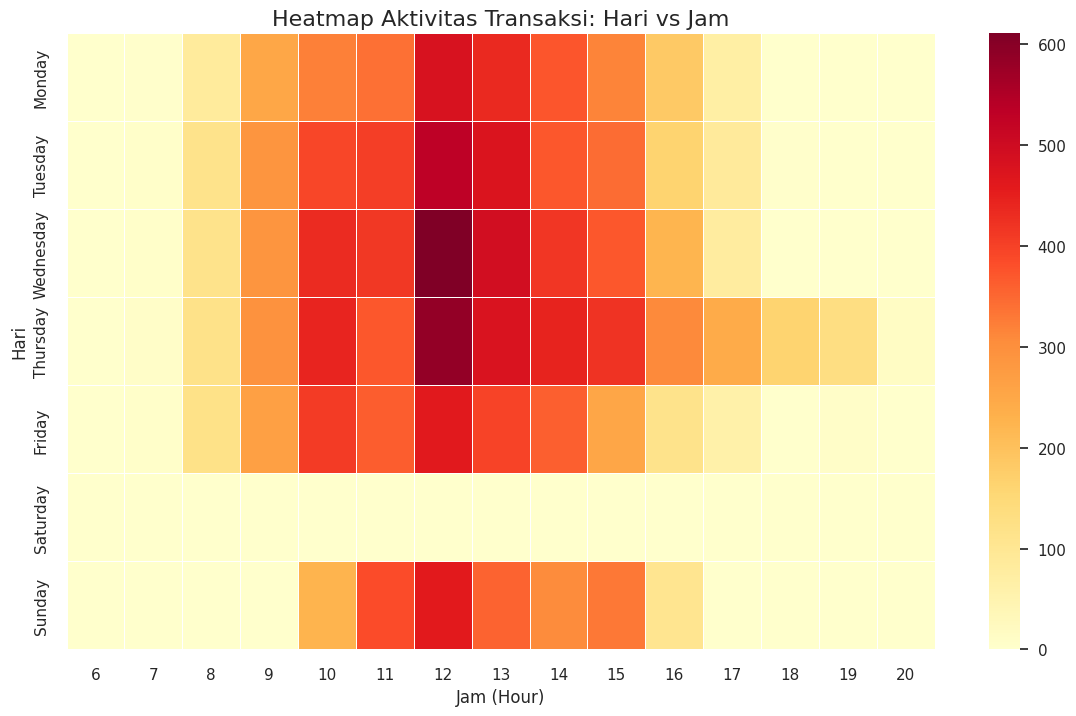

In [ ]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

order_pattern = df.groupby(['DayOfWeek', 'Hour'])['InvoiceNo'].nunique().reset_index()
pivot_table = order_pattern.pivot(index='DayOfWeek', columns='Hour', values='InvoiceNo')

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(order)

pivot_table = pivot_table.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=False, linewidths=.5)

plt.title('Heatmap Aktivitas Transaksi: Hari vs Jam', fontsize=16)
plt.xlabel('Jam (Hour)', fontsize=12)
plt.ylabel('Hari', fontsize=12)

plt.show()


Jumlah item unik: 3877


/tmp/ipython-input-1267161026.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


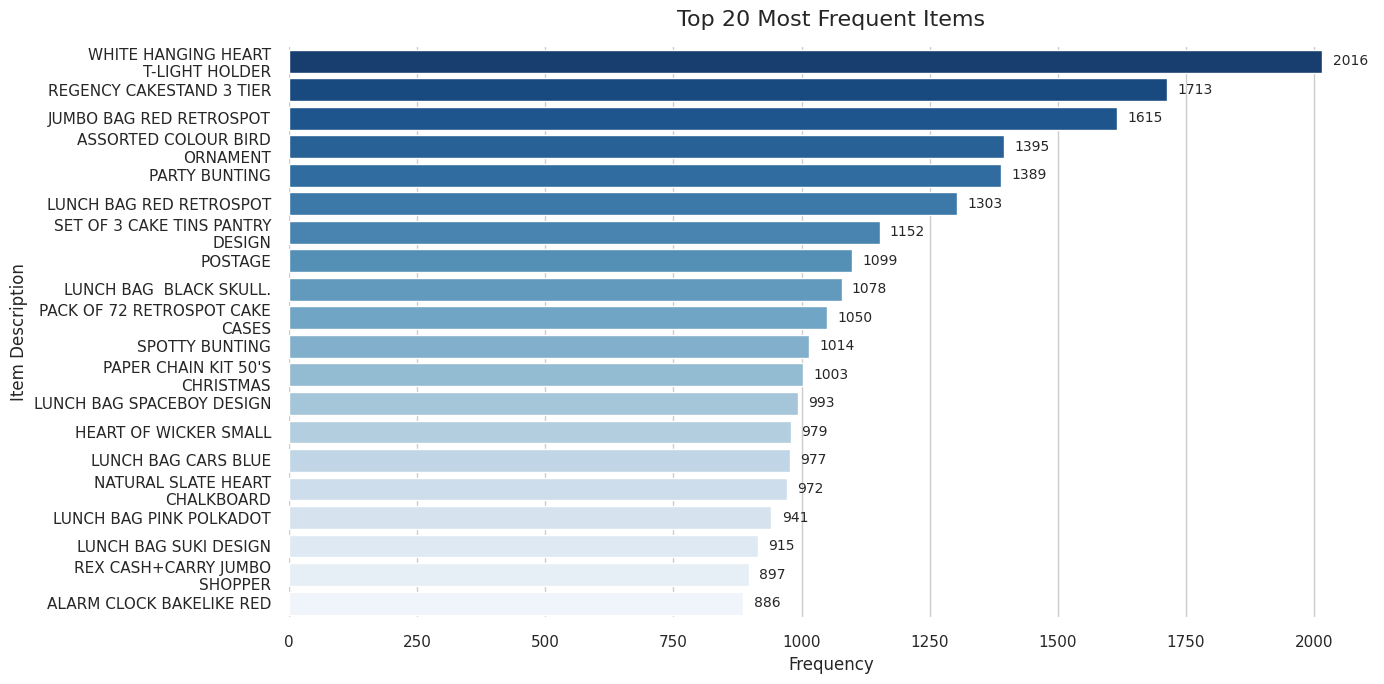

In [ ]:
item_counts = df['Description'].value_counts()

top_items = item_counts.head(20)

print("Jumlah item unik:", item_counts.shape[0])

plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

wrapped_labels_top = [textwrap.fill(label, 25) for label in top_items.index]

ax = sns.barplot(
    x=top_items.values,
    y=wrapped_labels_top,
    palette="Blues_r"
)

plt.title("Top 20 Most Frequent Items", fontsize=16, pad=15)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Item Description", fontsize=12)

for i, value in enumerate(top_items.values):
    ax.text(value + max(top_items.values)*0.01, i, str(value),
            va='center', fontsize=10)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



## Key Insights dari Eksplorasi Data

Berdasarkan analisis mendalam terhadap data historis, kami merangkum lima wawasan strategis yang mendefinisikan **karakteristik bisnis** dan **perilaku pelanggan** saat ini:

- **Tren Musiman yang Kuat (Seasonality Effect):**  
  Teridentifikasi adanya lonjakan pendapatan signifikan pada **kuartal akhir**, khususnya bulan **November dan Desember**. Menunjukkan bahwa **perilaku belanja pelanggan** sangat dipengaruhi oleh momentum akhir tahun (**Holiday Season**) dan persiapan Natal.

- **Dominasi Kategori Home & Gifting:**  
  Item dengan kinerja terbaik didominasi oleh **kategori kerajinan (craft) dan dekorasi rumah**, seperti *Paper Craft*, *Little Birdie*, *T-Light Holders*, hingga tas retro. Menegaskan posisi bisnis sebagai **retailer niche** untuk **hadiah dan dekorasi rumah unik**, bukan sekadar toserba umum.

- **Konsentrasi & Potensi Pasar Geografis:**  
  **United Kingdom** masih menjadi kontributor pendapatan terbesar (**pasar utama**). Data menunjukkan traksi organik yang menjanjikan dari **Eropa lainnya**, khususnya Belanda, EIRE (Irlandia), dan Jerman, menandakan adanya **peluang skalabilitas** untuk ekspansi lintas negara.

- **Optimasi Waktu Operasional:**  
  Pola transaksi harian mengungkapkan bahwa "**jam sibuk**" pelanggan terkonsentrasi di **siang hari**, antara pukul **10:00 hingga 15:00**, dengan hari **Kamis** sebagai puncak aktivitas. Tidak adanya data transaksi pada hari Sabtu mengonfirmasi bahwa toko tidak beroperasi pada hari tersebut, sebuah **celah yang bisa dievaluasi kembali** jika ingin memaksimalkan revenue di akhir pekan.

- **Produk dengan Perputaran Tertinggi (High Velocity Items):**  
  Analisis pada **Top 20 Most Frequent Items** mengungkap bahwa volume transaksi didominasi oleh barang-barang **berharga rendah (Low Ticket Items)** namun dengan **frekuensi pembelian berulang yang tinggi**. Item-item ini berfungsi sebagai **anchor products** yang efektif untuk menarik pelanggan kembali ke toko (**traffic driver**).  
  Strategi ketersediaan stok untuk 20 item ini sangat krusial karena **kekosongan stok (stockout)** pada item populer berisiko menurunkan **frekuensi kunjungan pelanggan** secara keseluruhan.


# 5. RFM Modelling

Untuk memahami **profil pelanggan**, data transaksi ditransformasi menjadi agregasi **level pelanggan** menggunakan metode **RFM**:

- **Recency (R):** Berapa hari sejak pembelian terakhir pelanggan? (Semakin kecil semakin baik).  
- **Frequency (F):** Berapa kali pelanggan melakukan transaksi unik? (Semakin besar semakin baik).  
- **Monetary (M):** Berapa total uang yang dibelanjakan pelanggan? (Semakin besar semakin baik).

Langkah-langkah utama dalam RFM Modelling:

1. **Menentukan Snapshot Date**  
   - Snapshot date ditentukan sebagai satu hari setelah transaksi terakhir dalam dataset.  
   - Snapshot date ini digunakan untuk menghitung Recency bagi setiap pelanggan.

2. **Membuat Tabel RFM**  
   - Data diaggregasi per pelanggan menggunakan CustomerID.  
   - Recency dihitung sebagai selisih hari antara snapshot date dan transaksi terakhir.  
   - Frequency dihitung sebagai jumlah transaksi unik per pelanggan.  
   - Monetary dihitung sebagai total nilai belanja per pelanggan.

3. **Pembersihan Data RFM**  
   - Menghapus nilai **infinity**, **NA**, atau **negatif** pada kolom Recency, Frequency, dan Monetary.  
   - Memastikan dataset RFM siap untuk analisis lebih lanjut.

4. **Analisis Distribusi RFM**  
   - Distribusi Recency, Frequency, dan Monetary divisualisasikan untuk memahami pola perilaku pelanggan.  
   - Membantu mengidentifikasi **pelanggan aktif**, **pelanggan loyal**, dan **pelanggan bernilai tinggi**.


In [ ]:
print('Start date:' , df['InvoiceDate'].min())
print('End date:' , df['InvoiceDate'].max())

Start date: 2010-12-01 08:26:00
End date: 2011-12-09 12:50:00


In [ ]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


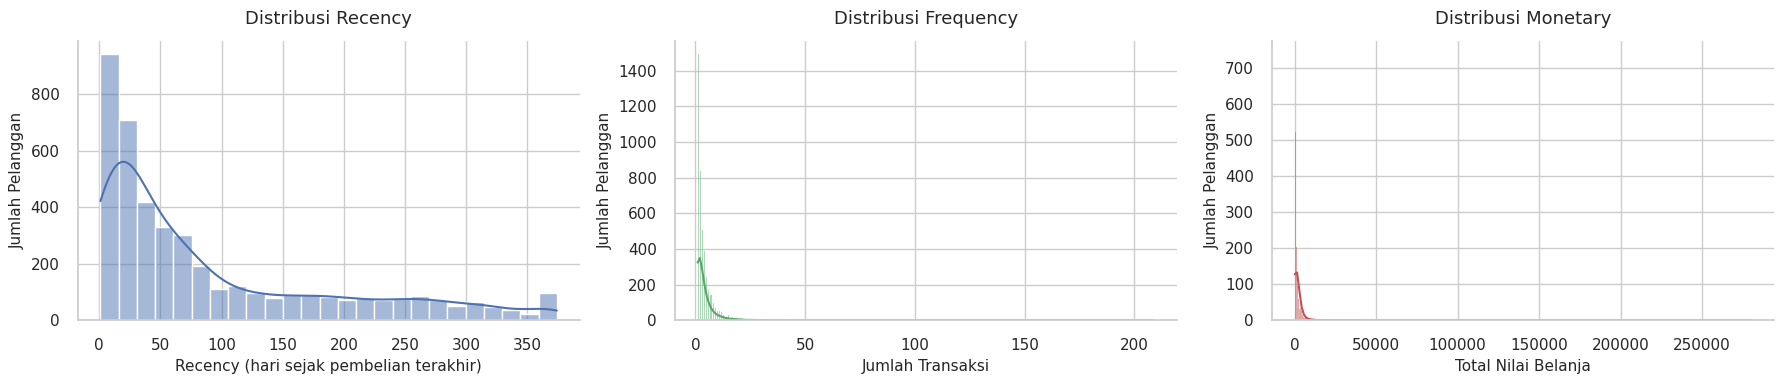

In [ ]:
sns.set_theme(style="whitegrid")
palette = ["#4C72B0", "#55A868", "#C44E52"]

rfm_clean = rfm.replace([np.inf, -np.inf], np.nan).dropna()

rfm_clean = rfm_clean[(rfm_clean['Recency'] >= 0) &
                      (rfm_clean['Frequency'] >= 0) &
                      (rfm_clean['Monetary'] >= 0)]

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(data=rfm_clean, x='Recency', kde=True, ax=axs[0], color=palette[0])
axs[0].set_title("Distribusi Recency", fontsize=13, pad=12)
axs[0].set_xlabel("Recency (hari sejak pembelian terakhir)", fontsize=11)
axs[0].set_ylabel("Jumlah Pelanggan", fontsize=11)

sns.histplot(data=rfm_clean, x='Frequency', kde=True, ax=axs[1], color=palette[1])
axs[1].set_title("Distribusi Frequency", fontsize=13, pad=12)
axs[1].set_xlabel("Jumlah Transaksi", fontsize=11)
axs[1].set_ylabel("Jumlah Pelanggan", fontsize=11)

sns.histplot(data=rfm_clean, x='Monetary', kde=True, ax=axs[2], color=palette[2])
axs[2].set_title("Distribusi Monetary", fontsize=13, pad=12)
axs[2].set_xlabel("Total Nilai Belanja", fontsize=11)
axs[2].set_ylabel("Jumlah Pelanggan", fontsize=11)

plt.tight_layout()
sns.despine()
plt.show()

# 6. Transformasi & Standardisasi Data RFM

Setelah melakukan analisis skewness, data RFM perlu **ditransformasi dan distandarisasi** agar siap untuk algoritma **K-Means**:

1. **Transformasi Power (Yeo-Johnson)**  
   - Digunakan metode **PowerTransformer (Yeo-Johnson)** untuk mendekatkan distribusi data ke **normal (Gaussian)**.  
   - Kolom yang ditransformasikan: `Recency`, `Frequency`, `Monetary`.  

2. **Standardisasi**  
   - Transformasi ini sekaligus **menstandarisasi** data (mean=0, std=1) agar semua variabel memiliki skala yang setara.  

3. **Visualisasi Distribusi Setelah Transformasi**  
   - Distribusi baru divisualisasikan untuk memastikan data mendekati distribusi normal dan siap untuk clustering.

---

### Informasi Dataset Setelah Transformasi

- Memastikan **tipe data** sesuai dan tidak ada missing value.  
- Melihat **statistik deskriptif** untuk menilai mean, std, min, max, dan distribusi data setelah transformasi.  

**Langkah Analisis:**
- `df_normalized.info()` → mengecek tipe data dan jumlah non-null.  
- `df_normalized.describe().round(2)` → ringkasan statistik numerik.  
- `df_normalized.isnull().sum()` → memastikan tidak ada missing value yang tersisa.


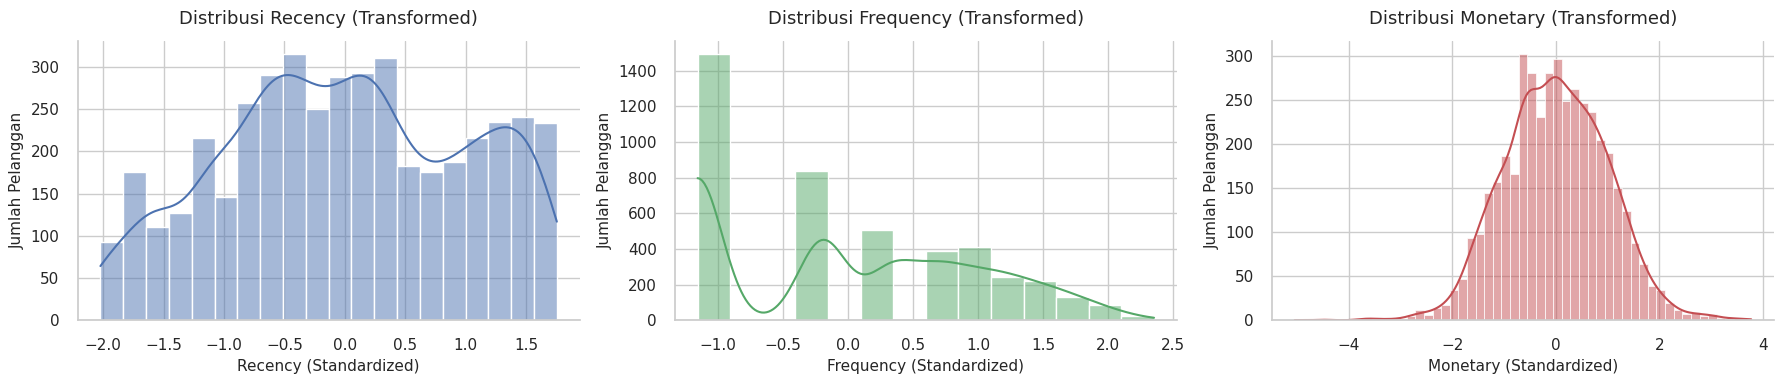

In [ ]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)

cols_for_clustering = ['Recency', 'Frequency', 'Monetary']
rfm_transformed = pt.fit_transform(rfm[cols_for_clustering])

df_normalized = pd.DataFrame(rfm_transformed, columns=cols_for_clustering)
df_normalized['CustomerID'] = rfm['CustomerID']

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(data=df_normalized, x='Recency', kde=True, ax=axs[0], color=palette[0])
axs[0].set_title("Distribusi Recency (Transformed)", fontsize=13, pad=12)
axs[0].set_xlabel("Recency (Standardized)", fontsize=11)
axs[0].set_ylabel("Jumlah Pelanggan", fontsize=11)

sns.histplot(data=df_normalized, x='Frequency', kde=True, ax=axs[1], color=palette[1])
axs[1].set_title("Distribusi Frequency (Transformed)", fontsize=13, pad=12)
axs[1].set_xlabel("Frequency (Standardized)", fontsize=11)
axs[1].set_ylabel("Jumlah Pelanggan", fontsize=11)

sns.histplot(data=df_normalized, x='Monetary', kde=True, ax=axs[2], color=palette[2])
axs[2].set_title("Distribusi Monetary (Transformed)", fontsize=13, pad=12)
axs[2].set_xlabel("Monetary (Standardized)", fontsize=11)
axs[2].set_ylabel("Jumlah Pelanggan", fontsize=11)

plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Recency     4338 non-null   float64
 1   Frequency   4338 non-null   float64
 2   Monetary    4338 non-null   float64
 3   CustomerID  4338 non-null   object 
dtypes: float64(3), object(1)
memory usage: 135.7+ KB


In [ ]:
df_normalized.describe().round(2)

,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.02,-1.16,-5.04
25%,-0.73,-1.16,-0.66
50%,-0.00,-0.20,-0.01
75%,0.84,0.89,0.70
max,1.76,2.35,3.77


In [ ]:
df_normalized.isnull().sum()

,0
Recency,0
Frequency,0
Monetary,0
CustomerID,0


# 7. K-Means Clustering & Evaluasi

Setelah data RFM ditransformasi dan distandarisasi, langkah selanjutnya adalah melakukan **K-Means Clustering** untuk segmentasi pelanggan.  

1. **Menentukan Jumlah Cluster Optimal (K)**  
   - Digunakan **Elbow Method** untuk menemukan K yang paling sesuai.  
   - Prinsip: mencari titik di mana penurunan **Sum of Squared Errors (SSE)** mulai melambat secara signifikan, membentuk **"siku" (elbow)**.  
   - Titik ini menunjukkan jumlah cluster yang cukup representatif tanpa overfitting.

2. **Evaluasi Cluster**  
   - Selain Elbow Method, evaluasi kualitas clustering dapat dilakukan menggunakan **Silhouette Score**.  
   - Silhouette Score memberikan indikasi seberapa baik setiap pelanggan cocok dengan cluster-nya sendiri dibandingkan dengan cluster lain.  
   - Nilai mendekati **1** menunjukkan cluster yang jelas terpisah dan konsisten.


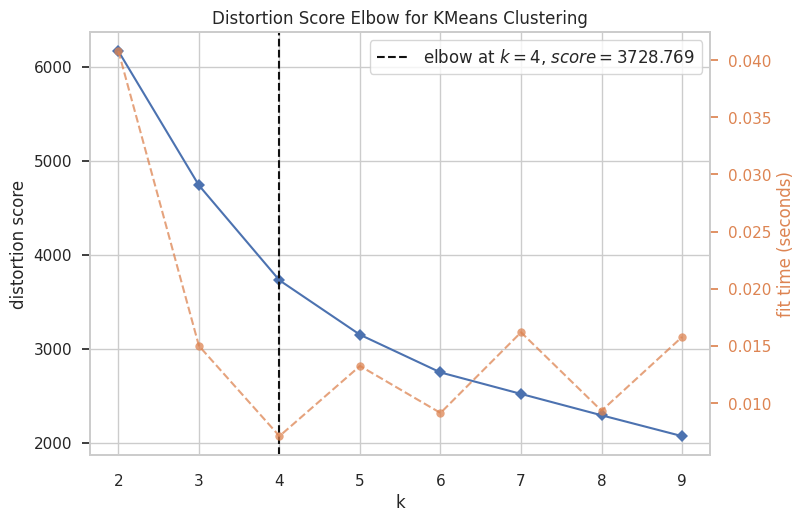

<Figure size 1000x500 with 0 Axes>


Skor Distortion untuk setiap nilai k:

[np.float64(6166.080778443056), np.float64(4738.39660806737), np.float64(3728.7690674756122), np.float64(3149.87733849571), np.float64(2748.8056563931905), np.float64(2520.388487558662), np.float64(2293.2391711888513), np.float64(2071.3512403241907)]
Jumlah cluster optimal (k): 4
Skor Distortion pada titik optimal: 3728.7690674756122


In [ ]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(df_normalized[["Recency", "Frequency", "Monetary"]])
plt.figure(figsize=(10, 5))
visualizer.show()

print("\nSkor Distortion untuk setiap nilai k:\n")
print(visualizer.k_scores_)


print(f"Jumlah cluster optimal (k): {visualizer.elbow_value_}")
print(f"Skor Distortion pada titik optimal: {visualizer.elbow_score_}")

In [ ]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans.fit(df_normalized[cols_for_clustering])

rfm_clean['Cluster'] = kmeans.labels_
df_normalized['Cluster'] = kmeans.labels_

cluster_summary = rfm_clean.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()

cluster_summary.rename(columns={'CustomerID': 'Count'}, inplace=True)
cluster_summary['Percentage'] = (cluster_summary['Count'] / cluster_summary['Count'].sum() * 100).round(1)

display(cluster_summary.style.background_gradient(cmap='YlGnBu', subset=['Recency', 'Frequency', 'Monetary']))

,Cluster,Recency,Frequency,Monetary,Count,Percentage
0,0,13.901852,10.707407,5966.396287,1080,24.900000
1,1,36.197286,1.423800,384.573498,958,22.100000
2,2,231.507491,1.193820,312.695112,1068,24.600000
3,3,84.806818,3.513799,1413.247657,1232,28.400000


In [ ]:
silhouette_avg = silhouette_score(rfm_transformed, kmeans.labels_)
print(f"Skor Siluet Rata-rata: {silhouette_avg:.2f}")

Skor Siluet Rata-rata: 0.33


# 8. Visualisasi & Interpretasi Hasil Clustering

Setelah melakukan **K-Means Clustering**, visualisasi digunakan untuk memahami **karakteristik setiap cluster** dan membandingkan perilaku pelanggan:

1. **Proporsi Pelanggan per Cluster**  
   - Diagram pie menunjukkan **persentase pelanggan** yang termasuk dalam masing-masing cluster.

2. **Heatmap Karakteristik RFM**  
   - Menampilkan **rata-rata nilai RFM** per cluster dalam angka asli.  
   - Membantu mengidentifikasi cluster dengan **Recency rendah**, **Frequency tinggi**, atau **Monetary tinggi**.

3. **Snake Plot (Line Plot RFM)**  
   - Memvisualisasikan **perbandingan karakteristik cluster** berdasarkan **nilai RFM yang telah distandarisasi**.  
   - Membantu mengenali **pola perilaku pelanggan** antar cluster secara langsung.


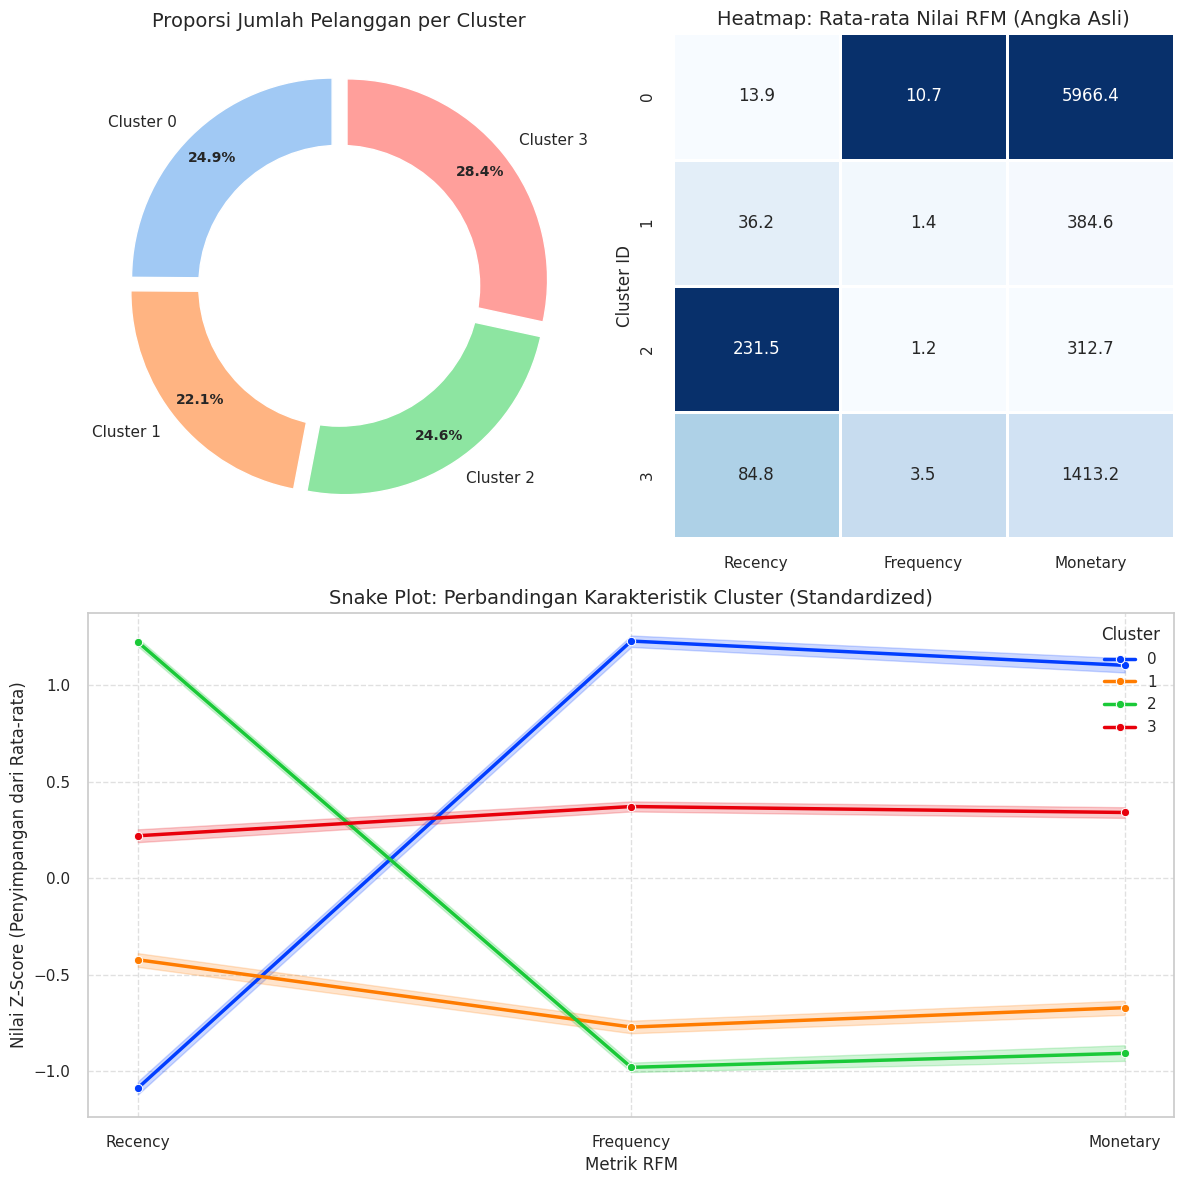

In [ ]:
df_melt = pd.melt(df_normalized.reset_index(),
                  id_vars=['Cluster'],
                  value_vars=['Recency', 'Frequency', 'Monetary'],
                  var_name='Metric',
                  value_name='Value')

fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
cluster_counts = rfm_clean['Cluster'].value_counts().sort_index()
colors = sns.color_palette('pastel')[0:4]

wedges, texts, autotexts = ax1.pie(cluster_counts, labels=[f"Cluster {i}" for i in cluster_counts.index],
                                   autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.85, explode=[0.05]*4)

centre_circle = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle)
ax1.set_title('Proporsi Jumlah Pelanggan per Cluster', fontsize=14)
plt.setp(autotexts, size=10, weight="bold")

ax2 = fig.add_subplot(gs[0, 1])
summary_numeric = cluster_summary[['Recency', 'Frequency', 'Monetary']]

summary_scaled = (summary_numeric - summary_numeric.min()) / (summary_numeric.max() - summary_numeric.min())

sns.heatmap(summary_scaled, annot=cluster_summary[['Recency', 'Frequency', 'Monetary']],
            fmt='.1f', cmap='Blues', linewidths=1, ax=ax2, cbar=False)
ax2.set_title('Heatmap: Rata-rata Nilai RFM (Angka Asli)', fontsize=14,)
ax2.set_ylabel('Cluster ID')


ax3 = fig.add_subplot(gs[1, :])
sns.lineplot(data=df_melt, x='Metric', y='Value', hue='Cluster',
             palette='bright', marker='o', linewidth=2.5, ax=ax3)

ax3.set_title('Snake Plot: Perbandingan Karakteristik Cluster (Standardized)', fontsize=14)
ax3.set_xlabel('Metrik RFM', fontsize=12)
ax3.set_ylabel('Nilai Z-Score (Penyimpangan dari Rata-rata)', fontsize=12)
ax3.legend(title='Cluster', loc='upper right')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 9. Analisis Detail & Rekomendasi Bisnis

Berdasarkan hasil **RFM Clustering**, setiap segmen pelanggan dianalisis secara mendalam untuk memahami karakteristik, perilaku, dan strategi bisnis yang tepat.

---

## Cluster 0: Champions (Pelanggan VIP)

**Karakteristik:**

- **Recency:** 14 hari (sangat baru berbelanja)  
- **Frequency:** 10.7 transaksi (paling sering bertransaksi)  
- **Monetary:** £5,966 (High Spender, penyumbang pendapatan terbesar)  

**Insight:**  
Ini adalah **aset terbesar perusahaan**. Mereka sangat loyal dan tidak sensitif terhadap diskon murah. Jangan ganggu mereka dengan promosi yang tidak relevan.

**Rekomendasi Bisnis:**

- **Early Access:** Akses pertama ke produk baru
= **Member Birthday:** Privilege yang didapatkan mereka ketika ulang tahun
- **Referral Program:** Ajak mereka merekomendasikan teman dengan insentif menarik

---

## Cluster 1: Potential Loyalists (Pelanggan Baru)

**Karakteristik:**

- **Recency:** 36 hari (cukup aktif)  
- **Frequency:** 1.4 transaksi (baru mencoba 1-2 kali)  
- **Monetary:** £384 (nilai belanja masih kecil)  

**Insight:**  
Pelanggan baru yang sedang mencoba produk. Tantangan: meningkatkan frekuensi pembelian kedua dan ketiga.

**Rekomendasi Bisnis:**

- **Discount bundling (Welcome Gift):** Diskon yang tidak terlalu besar (5%) based FP-Growth
- **Campaign ads email:** Reminder how to repurchase, rekomendasi best seller product

---

## Cluster 3: At Risk (Perlu Perhatian)

**Karakteristik:**

- **Recency:** 85 hari (sudah hampir 3 bulan tidak berbelanja)  
- **Frequency:** 3.5 transaksi (dulu lumayan sering)  
- **Monetary:** £1,413 (Medium Spender)  

**Insight:**  
Kelompok ini **paling krusial**. Mereka dulu pelanggan baik, tapi mulai meninggalkan bisnis. Harus segera diaktifkan kembali.

**Rekomendasi Bisnis:**

- **Reactivation Campaign:** Email/notifikasi "Kami Rindu Anda"
- **Promo Agresif:** Diskon lebih besar daripada Cluster 1 untuk menarik kembali sekitar 15-25%

---

## Cluster 2: Lost / Hibernating (Pelanggan Hilang)

**Karakteristik:**

- **Recency:** 231 hari (>7 bulan, sangat lama tidak berbelanja)  
- **Frequency:** 1.2 transaksi (jarang berbelanja)  
- **Monetary:** £312 (kontribusi uang paling sedikit)  

**Insight:**  
Pelanggan sudah **churn**, mengembalikan mereka mahal dan tingkat keberhasilannya rendah.

**Rekomendasi Bisnis:**

- **Prioritas Rendah:** Jangan habiskan budget marketing besar  
- **Soft Win-Back Otomatis:** Email automation standar saat event besar (Harbolnas/Lebaran)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,order_date,order_time,Month_Year,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,08:26:00,2010-12,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00,2010-12,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,08:26:00,2010-12,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00,2010-12,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,08:26:00,2010-12,Wednesday,8


In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [ ]:
df['CustomerID'] = df['CustomerID'].astype(str)
rfm['CustomerID'] = rfm_clean['CustomerID'].astype(str)

merged_df = df.merge(
    rfm_clean[['CustomerID', 'Cluster']],
    on='CustomerID',
    how='inner'
)

Total Baris: 392692 | Total User: 4338

Memulai visualisasi per cluster...



/tmp/ipython-input-2883565595.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_qty['Quantity'], y=wrapped_labels_qty, ax=axes[0], palette="Blues_r")
/tmp/ipython-input-2883565595.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rev['Revenue'], y=wrapped_labels_rev, ax=axes[1], palette="Greens_r")


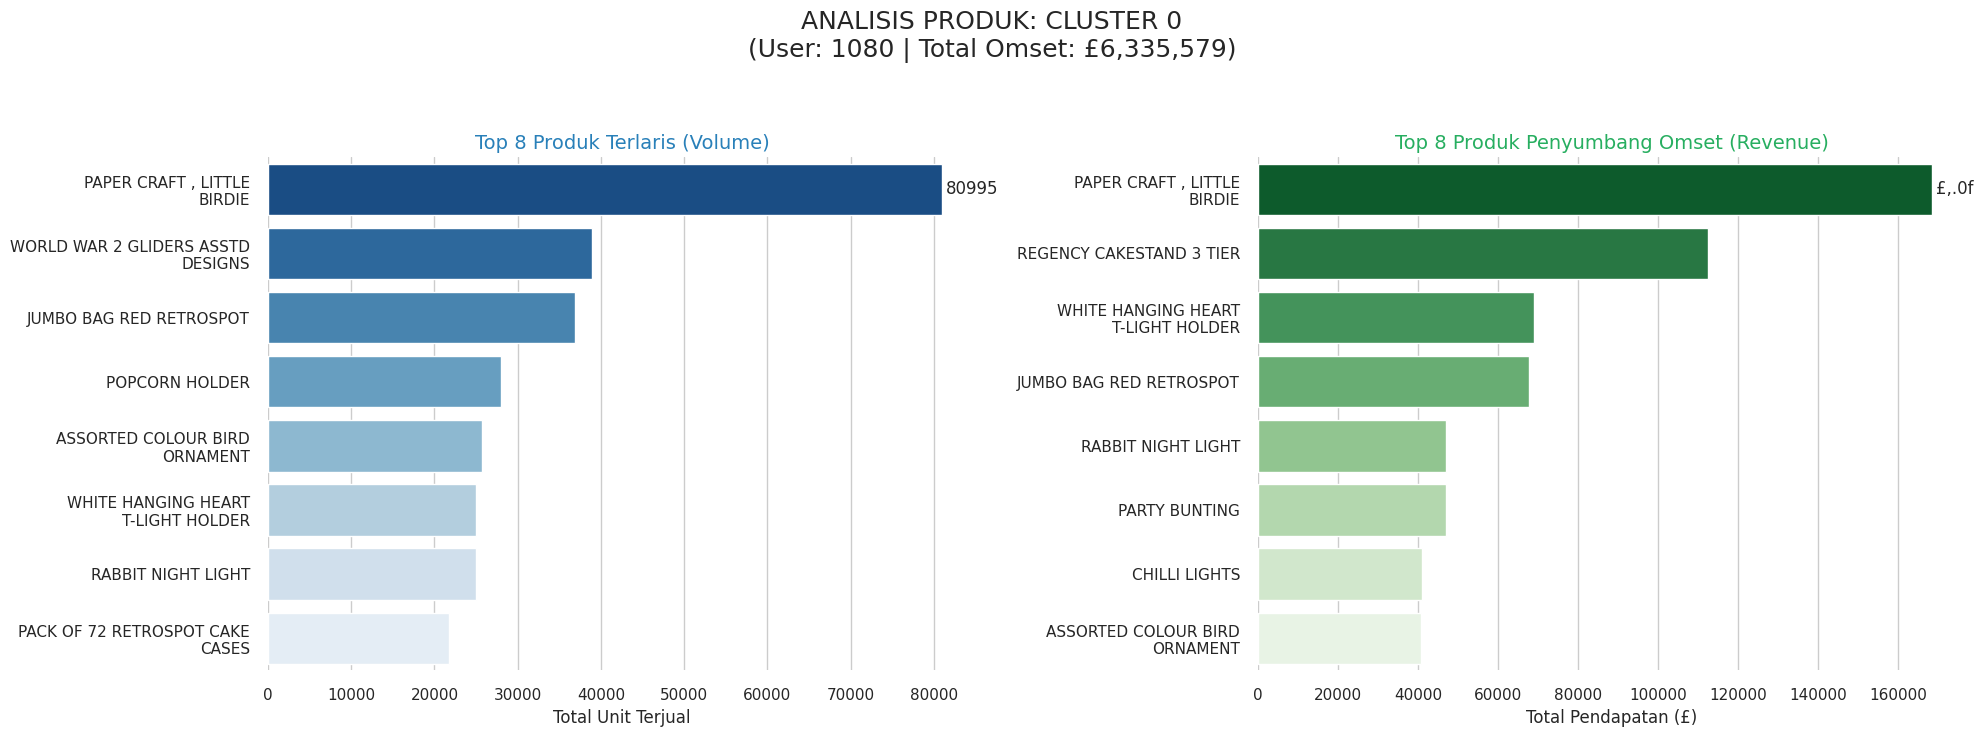

/tmp/ipython-input-2883565595.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_qty['Quantity'], y=wrapped_labels_qty, ax=axes[0], palette="Blues_r")
/tmp/ipython-input-2883565595.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rev['Revenue'], y=wrapped_labels_rev, ax=axes[1], palette="Greens_r")


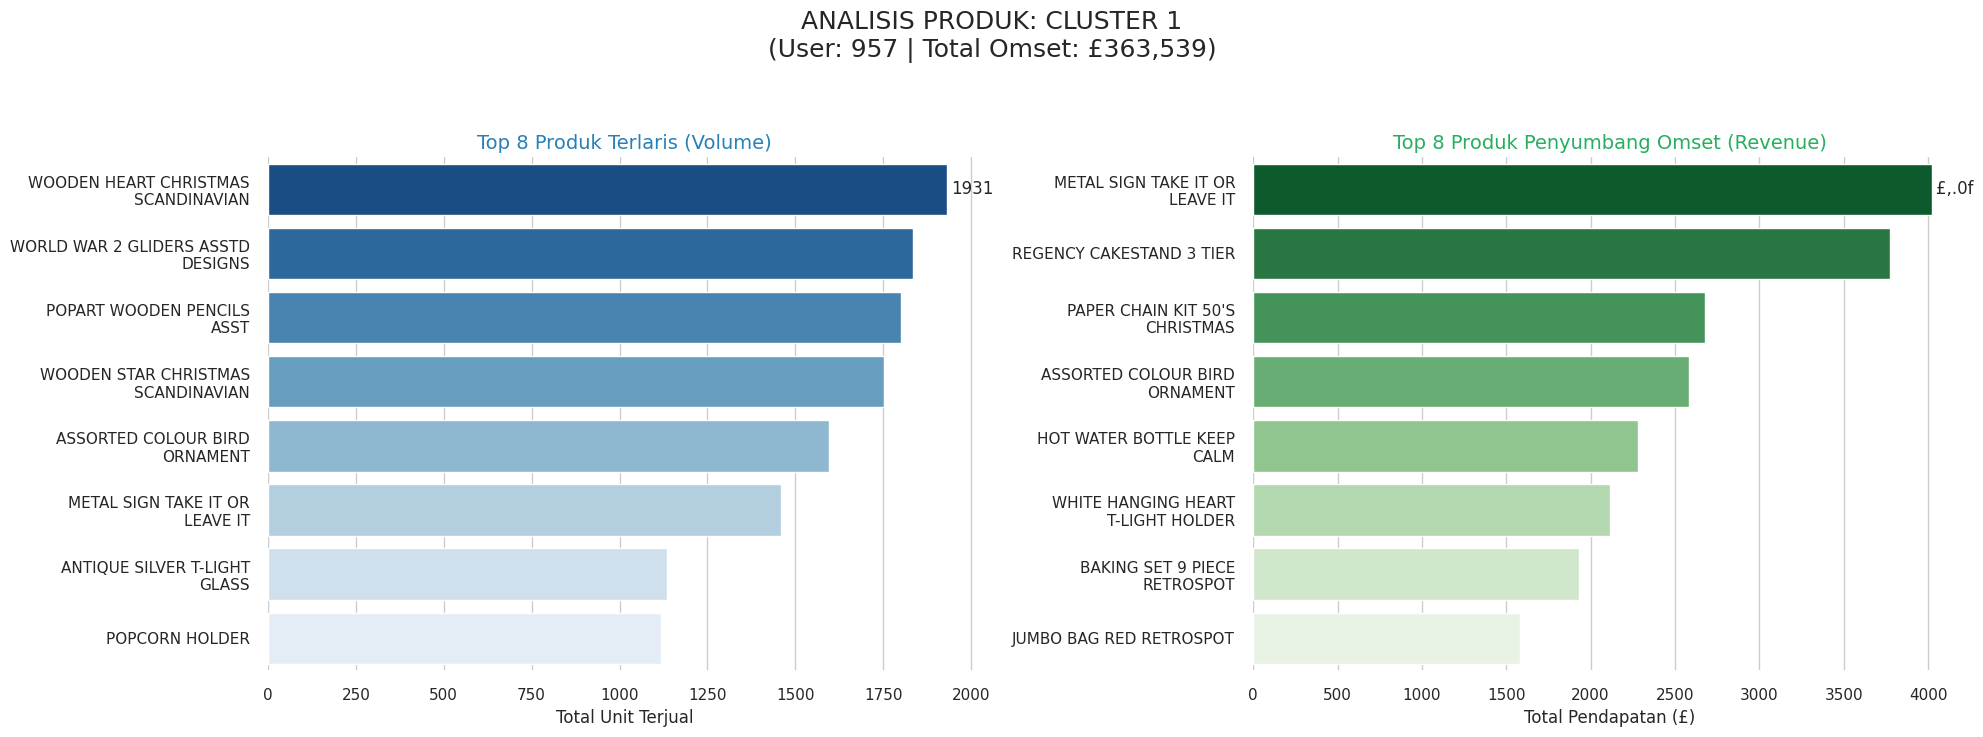

/tmp/ipython-input-2883565595.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_qty['Quantity'], y=wrapped_labels_qty, ax=axes[0], palette="Blues_r")
/tmp/ipython-input-2883565595.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rev['Revenue'], y=wrapped_labels_rev, ax=axes[1], palette="Greens_r")


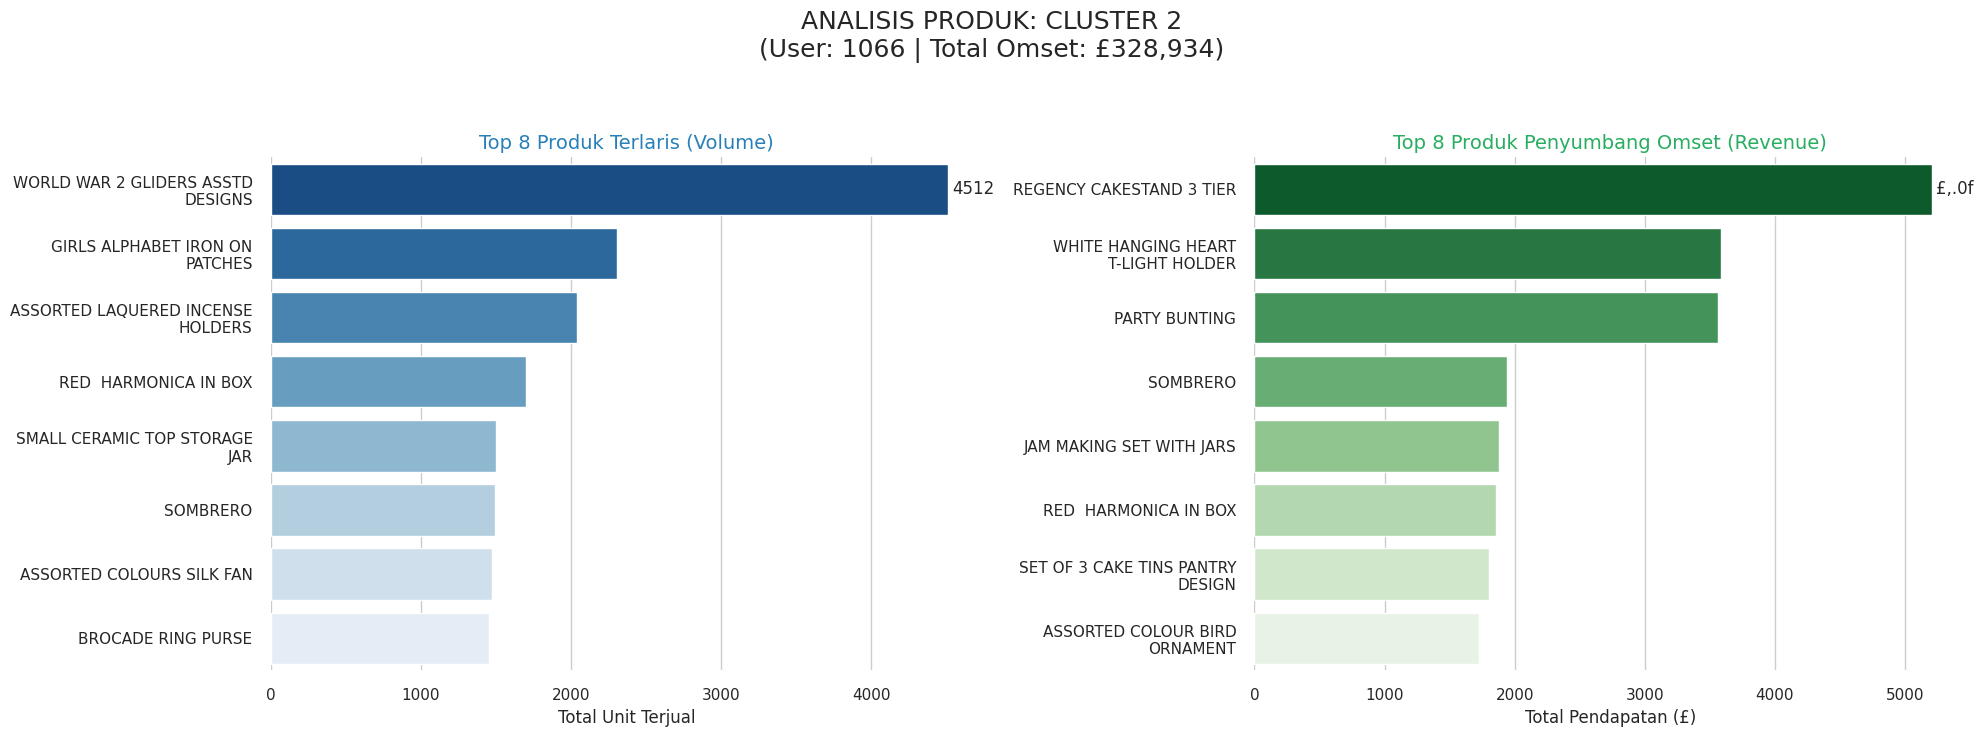

/tmp/ipython-input-2883565595.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_qty['Quantity'], y=wrapped_labels_qty, ax=axes[0], palette="Blues_r")
/tmp/ipython-input-2883565595.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rev['Revenue'], y=wrapped_labels_rev, ax=axes[1], palette="Greens_r")


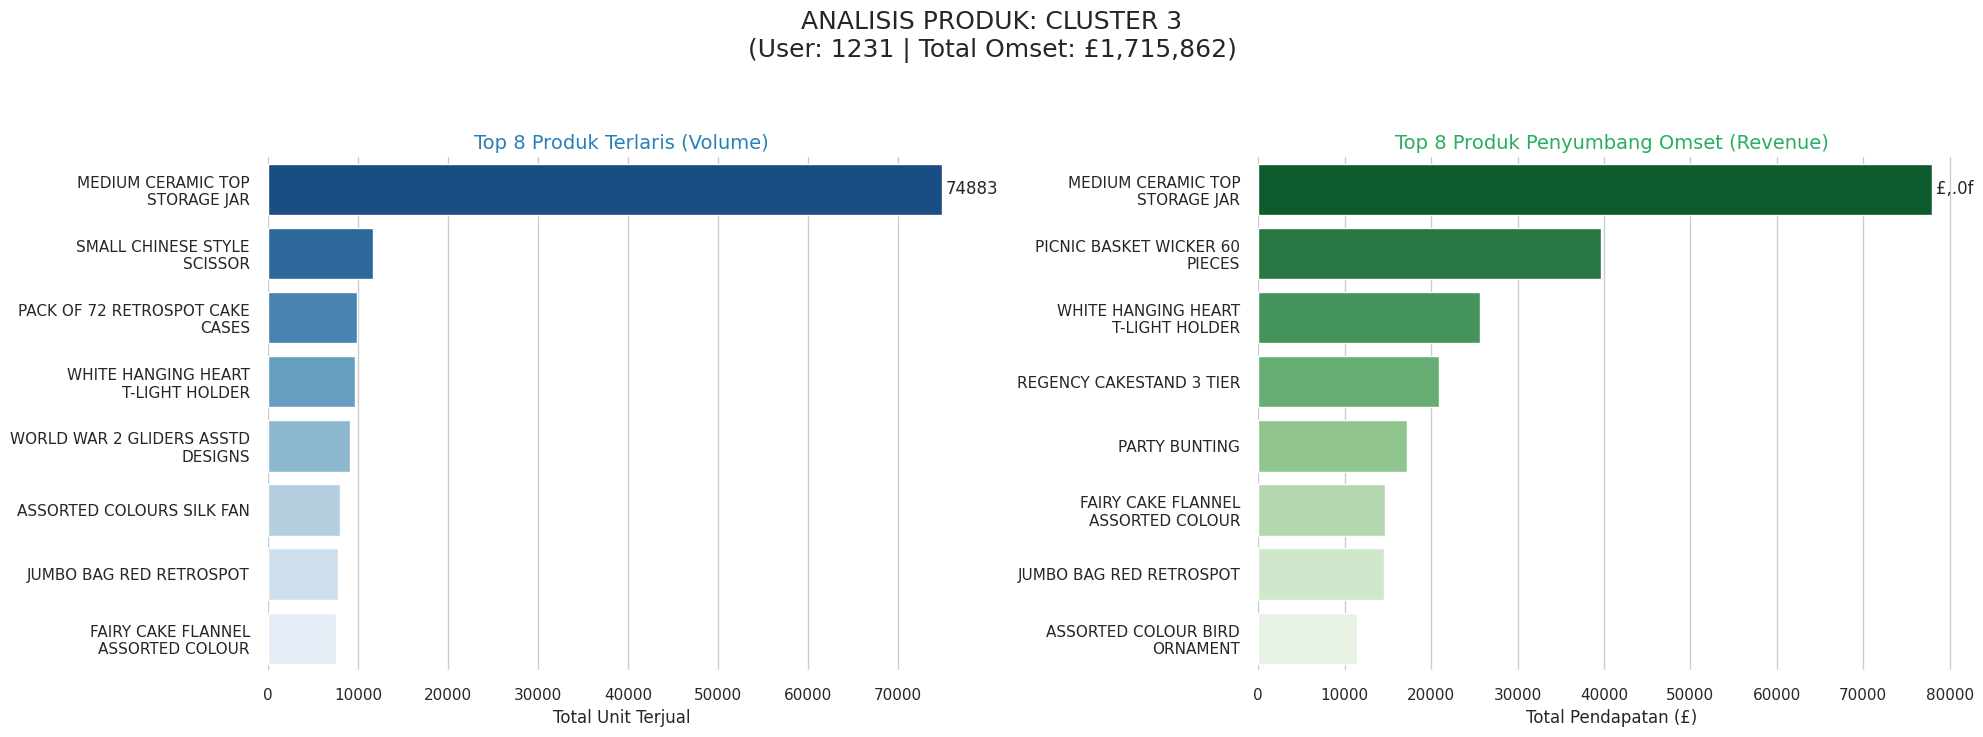

In [ ]:
def visualize_cluster_products_final(cluster_id, data, top_n=10):
    cluster_df = data[data['Cluster'] == cluster_id]

    excluded_items = [
        'POSTAGE', 'DOTCOM POSTAGE', 'Manual', 'Bank Charges',
        'Discount', 'CRUK Commission', 'SAMPLES'
    ]
    cluster_df = cluster_df[~cluster_df['Description'].isin(excluded_items)]

    product_summary = cluster_df.groupby('Description').agg({
        'Quantity': 'sum',
        'Revenue': 'sum'
    }).reset_index()

    top_qty = product_summary.sort_values(by='Quantity', ascending=False).head(top_n)
    top_rev = product_summary.sort_values(by='Revenue', ascending=False).head(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    total_rev = cluster_df['Revenue'].sum()
    total_users = cluster_df['CustomerID'].nunique()

    fig.suptitle(
        f'ANALISIS PRODUK: CLUSTER {cluster_id}\n(User: {total_users} | Total Omset: £{total_rev:,.0f})',
        fontsize=18, y=1.05
    )

    wrapped_labels_qty = [textwrap.fill(str(label), 25) for label in top_qty['Description']]
    sns.barplot(x=top_qty['Quantity'], y=wrapped_labels_qty, ax=axes[0], palette="Blues_r")

    axes[0].set_title(f"Top {top_n} Produk Terlaris (Volume)", fontsize=14, color='#2980b9')
    axes[0].set_xlabel("Total Unit Terjual")
    axes[0].set_ylabel("")
    axes[0].bar_label(axes[0].containers[0], padding=3, fmt='%d')

    wrapped_labels_rev = [textwrap.fill(str(label), 25) for label in top_rev['Description']]
    sns.barplot(x=top_rev['Revenue'], y=wrapped_labels_rev, ax=axes[1], palette="Greens_r")

    axes[1].set_title(f"Top {top_n} Produk Penyumbang Omset (Revenue)", fontsize=14, color='#27ae60')
    axes[1].set_xlabel("Total Pendapatan (£)")
    axes[1].set_ylabel("")
    axes[1].bar_label(axes[1].containers[0], padding=3, fmt='£,.0f')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

unique_clusters = sorted(merged_df['Cluster'].unique())

for cluster in unique_clusters:
    visualize_cluster_products_final(cluster_id=cluster, data=merged_df, top_n=8)

In [ ]:
EXCLUDED_ITEMS = [
    'POSTAGE', 'DOTCOM POSTAGE', 'Manual', 'Bank Charges',
    'Discount', 'CRUK Commission', 'SAMPLES'
]

def get_cluster_recommendations(
    dataframe: pd.DataFrame,
    cluster_id: int,
    target_metric: str = 'lift',
    min_support: float = 0.01,
    min_threshold: float = 1.0,
    top_n: int = 10
) -> pd.DataFrame:

    subset = dataframe[dataframe['Cluster'] == cluster_id]
    subset = subset[~subset['Description'].isin(EXCLUDED_ITEMS)]

    if subset.empty:
        print(f"Data kosong untuk Cluster {cluster_id}")
        return pd.DataFrame()

    basket = subset.groupby(['InvoiceNo', 'Description'])['Quantity'] \
                   .sum().unstack(fill_value=0)

    basket_sets = (basket > 0).astype(int)

    frequent_itemsets = fpgrowth(basket_sets, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        return pd.DataFrame()

    rules = association_rules(frequent_itemsets, metric=target_metric, min_threshold=min_threshold)

    if rules.empty:
        return pd.DataFrame()

    top_rules = rules.sort_values(by=target_metric, ascending=False).head(top_n)

    cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    return top_rules[cols]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
rec_new_cust = get_cluster_recommendations(
    merged_df,
    cluster_id=1,
    target_metric='confidence',
    min_support=0.01
)

rec_new_cust

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,support,confidence,lift
0,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.010309,1.0,42.437500
1,"(SET OF 12 FAIRY CAKE BAKING CASES, SET OF 6 T...",(SET OF 12 MINI LOAF BAKING CASES),0.011046,1.0,29.521739
2,"(ASSORTED COLOUR BIRD ORNAMENT, WOODEN TREE CH...",(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.010309,1.0,15.976471


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

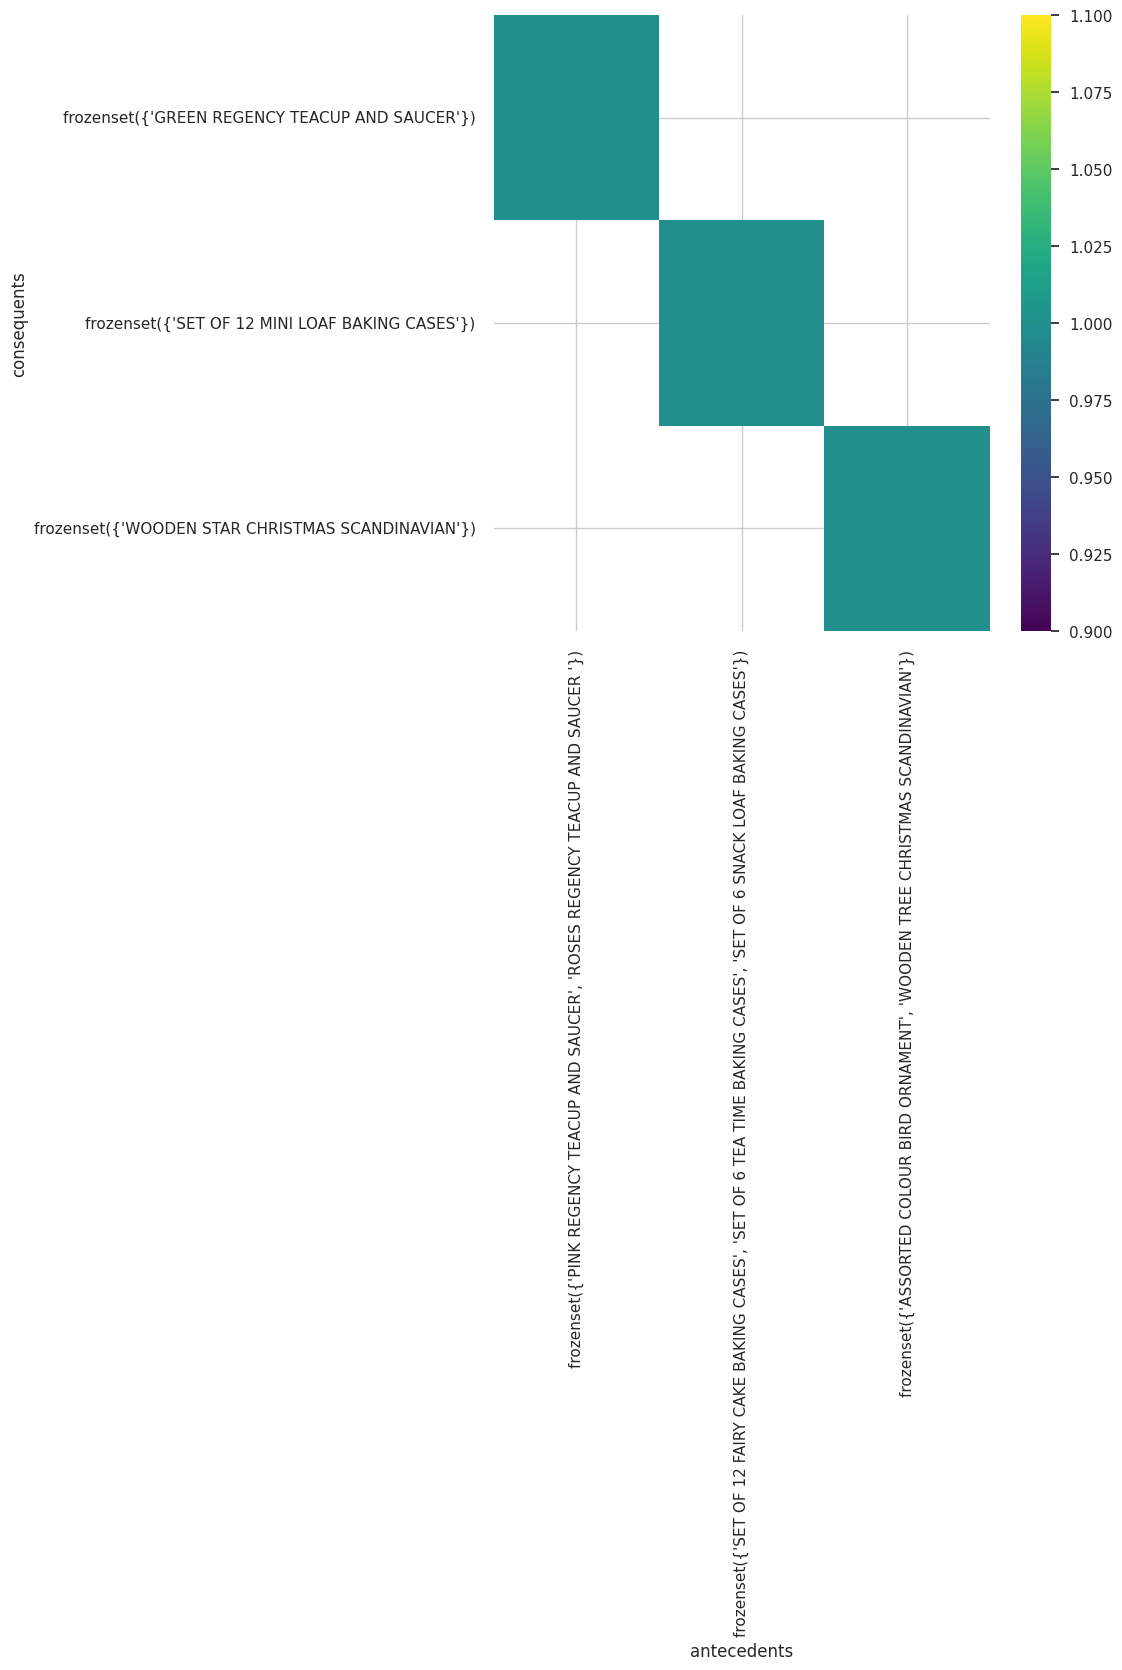

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['consequents'].value_counts()
    for x_label, grp in rec_new_cust.groupby('antecedents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('antecedents')
_ = plt.ylabel('consequents')

In [ ]:
rec_winback = get_cluster_recommendations(
    merged_df,
    cluster_id=3,
    target_metric='lift',
    min_support=0.02,
    min_threshold=1.2
)
rec_winback

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,support,confidence,lift
32,(PINK HAPPY BIRTHDAY BUNTING),(BLUE HAPPY BIRTHDAY BUNTING),0.020484,0.792793,31.830260
33,(BLUE HAPPY BIRTHDAY BUNTING),(PINK HAPPY BIRTHDAY BUNTING),0.020484,0.822430,31.830260
42,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.020484,0.698413,23.440476
43,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.020484,0.687500,23.440476
51,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.024441,0.744681,22.371671
50,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.024441,0.734266,22.371671
49,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.024441,0.921053,21.622088
52,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.024441,0.573770,21.622088
45,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.028631,0.672131,20.478549
44,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.028631,0.872340,20.478549


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

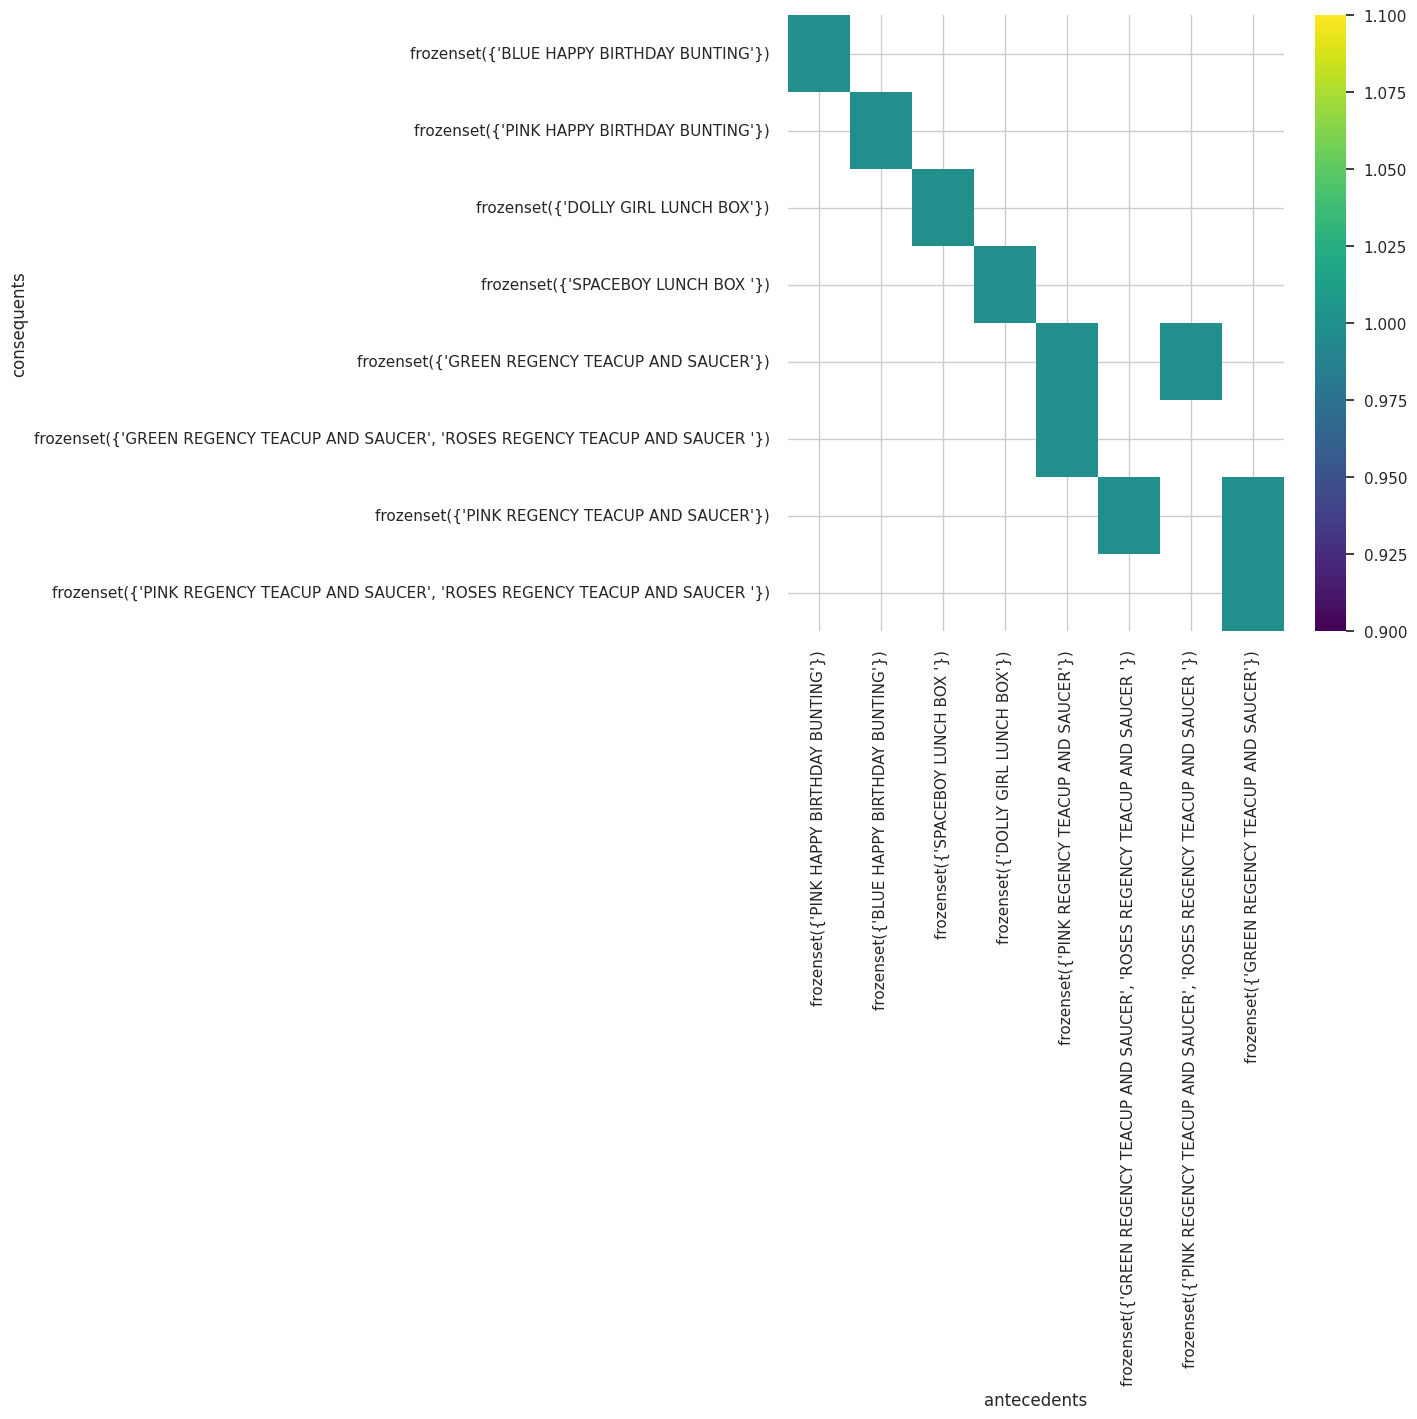

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['consequents'].value_counts()
    for x_label, grp in rec_winback.groupby('antecedents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('antecedents')
_ = plt.ylabel('consequents')

In [ ]:
def build_price_reference(transactions_df):
    return (
        transactions_df[transactions_df['UnitPrice'] > 0]
        .groupby('Description')['UnitPrice']
        .median()
        .to_dict()
    )

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
def calculate_itemset_price(itemset, price_reference):
    if isinstance(itemset, str):
        items = itemset.split(', ')
    else:
        items = list(itemset)

    return sum(price_reference.get(item, 0) for item in items)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
def append_normal_price(rules_df, price_reference):
    df = rules_df.copy()

    if not isinstance(df['antecedents'].iloc[0], str):
        df['antecedents'] = df['antecedents'].apply(lambda x: ', '.join(list(x)))
        df['consequents'] = df['consequents'].apply(lambda x: ', '.join(list(x)))

    df['price_antecedents'] = df['antecedents'].apply(lambda x: calculate_itemset_price(x, price_reference))
    df['price_consequents'] = df['consequents'].apply(lambda x: calculate_itemset_price(x, price_reference))

    df['normal_bundle_price'] = (df['price_antecedents'] + df['price_consequents'])

    return df

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
def determine_discount_strategy(row, customer_cluster):
    if customer_cluster == 3:
        metric = row['lift']

        if metric >= 2.0:
            return 15, "Win-Back Special"
        elif metric >= 1.2:
            return 20, "We Miss You Promo"
        else:
            return 25, "Last Chance Deal"

    elif customer_cluster == 1:
        metric = row['confidence']

        if metric >= 0.7:
            return 5, "Welcome Gift"
        else:
            return 10, "1st Purchase Bonus"

    return 0, "Regular Price"

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
def generate_smart_pricing(association_rules_df, transactions_df, customer_cluster):
    if association_rules_df.empty:
        return association_rules_df

    price_reference = build_price_reference(transactions_df)

    pricing_df = append_normal_price(
        association_rules_df,
        price_reference
    )

    discount_results = pricing_df.apply(
        lambda row: determine_discount_strategy(row, customer_cluster),
        axis=1
    )

    pricing_df['discount_percent'] = discount_results.apply(lambda x: x[0])
    pricing_df['promo_label'] = discount_results.apply(lambda x: x[1])

    pricing_df['promo_price'] = (
        pricing_df['normal_bundle_price'] *
        (1 - pricing_df['discount_percent'] / 100)
        )

    return pricing_df[
        [
            'antecedents',
            'consequents',
            'normal_bundle_price',
            'promo_price',
            'discount_percent',
            'promo_label',
            'lift',
            'confidence'
        ]
    ]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
## PROMO PRICING | CLUSTER 3 (AT RISK)

promo_winback = generate_smart_pricing(
    association_rules_df=rec_winback,
    transactions_df=merged_df,
    customer_cluster=3
)

promo_winback.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PROMO PRICING | CLUSTER 3 (AT RISK)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,normal_bundle_price,promo_price,discount_percent,promo_label,lift,confidence
32,PINK HAPPY BIRTHDAY BUNTING,BLUE HAPPY BIRTHDAY BUNTING,10.90,9.2650,15,Win-Back Special,31.830260,0.792793
33,BLUE HAPPY BIRTHDAY BUNTING,PINK HAPPY BIRTHDAY BUNTING,10.90,9.2650,15,Win-Back Special,31.830260,0.822430
42,SPACEBOY LUNCH BOX,DOLLY GIRL LUNCH BOX,3.90,3.3150,15,Win-Back Special,23.440476,0.698413
43,DOLLY GIRL LUNCH BOX,SPACEBOY LUNCH BOX,3.90,3.3150,15,Win-Back Special,23.440476,0.687500
51,PINK REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY...",8.85,7.5225,15,Win-Back Special,22.371671,0.744681


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
## PROMO PRICING | CLUSTER 1 (LOYALIST)

promo_new_customer = generate_smart_pricing(
    association_rules_df=rec_new_cust,
    transactions_df=merged_df,
    customer_cluster=1
)

promo_new_customer.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PROMO PRICING | CLUSTER 1 (NEW CUSTOMER)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,normal_bundle_price,promo_price,discount_percent,promo_label,lift,confidence
0,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",GREEN REGENCY TEACUP AND SAUCER,8.85,8.4075,5,Welcome Gift,42.437500,1.0
1,"SET OF 12 FAIRY CAKE BAKING CASES, SET OF 6 TE...",SET OF 12 MINI LOAF BAKING CASES,3.74,3.5530,5,Welcome Gift,29.521739,1.0
2,"ASSORTED COLOUR BIRD ORNAMENT, WOODEN TREE CHR...",WOODEN STAR CHRISTMAS SCANDINAVIAN,2.27,2.1565,5,Welcome Gift,15.976471,1.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
